#### Why Segmentation

If you want to increase retention rate, you can do a segmentation based on churn probability and take actions. But there are very common and useful segmentation methods as well. Now we are going to implement one of them to our business: RFM.

#### RFM stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:

- **Low Value:** Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.

- **Mid Value:** In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.

- **High Value:** The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

In [2]:
# ∗∗∗∗∗∗∗∗∗∗ Important – Do not use in production, for demonstration purposes only – please review the legal notices before continuing ∗∗∗∗∗

# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division


StatementMeta(, , , SessionError, )

AVAILABLE_WORKSPACE_CAPACITY_EXCEEDED: Livy session has failed. Session state: Error. Error code: AVAILABLE_WORKSPACE_CAPACITY_EXCEEDED. Your job requested 24 vcores. However, the workspace only has 18 vcores available out of quota of 50 vcores. Try ending the running job(s), reducing the numbers of vcores requested or increasing your vcore quota. Source: User.

In [1]:
#!conda install -c conda-forge cufflinks-py
#!conda install -c plotly chart-studio

import chart_studio
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.offline as pyoff


StatementMeta(, , , SessionError, )

AVAILABLE_WORKSPACE_CAPACITY_EXCEEDED: Livy session has failed. Session state: Error. Error code: AVAILABLE_WORKSPACE_CAPACITY_EXCEEDED. Your job requested 24 vcores. However, the workspace only has 18 vcores available out of quota of 50 vcores. Try ending the running job(s), reducing the numbers of vcores requested or increasing your vcore quota. Source: User.

In [ ]:
#inititate Plotly
pyoff.init_notebook_mode()

###### As the methodology, we need to calculate Recency, Frequency and Monetary Value (we will call it Revenue from now on) and apply unsupervised machine learning to identify different groups (clusters) for each. Let’s jump into coding and see how to do RFM Clustering.

In [ ]:
#load dataset
#data source: https://www.kaggle.com/vijayuv/onlineretail
import pip
pip.main(["install", "xlrd"])
tx_data = pd.read_excel('abfss://customer-churn-data@#STORAGE_ACCOUNT_NAME#.dfs.core.windows.net/online_retail_II.xlsx')

In [ ]:
#lets see the dataset
tx_data

In [ ]:
#convert the string date field to datetime
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

In [ ]:
tx_data['InvoiceDate'].describe()

In [ ]:
#we will be using only UK data (we can filter data for others countries also)
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

In [ ]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
tx_user = pd.DataFrame(tx_data['CustomerID'].unique())
tx_user.columns = ['CustomerID']

# Recency

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [ ]:
#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase

In [ ]:
#we take our observation point as the max invoice date in our dataset
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [ ]:
#merge this dataframe to our new user dataframe
#Our new dataframe tx_user contains recency data now:

tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')
tx_user.head()

In [228]:
#To get a snapshot about how recency looks like, we can use pandas’ .describe() method. 
#It shows mean, min, max, count and percentiles of our data.
tx_user.Recency.describe()

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

We see that even though the average is 90 day recency, median is 49.

#### to show us how is the distribution of recency across our customers.

In [229]:
#plot a recency histogram
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

- Now it is the fun part. We are going to apply K-means clustering to assign a recency score. But we should tell how many clusters we need to K-means algorithm. 

- To find it out, we will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia. Code snippet and Inertia graph are as follows:

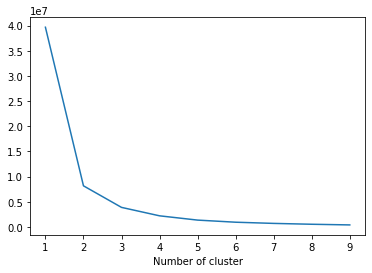

In [230]:
from sklearn.cluster import KMeans

sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Here it looks like 3 is the optimal one. we can go ahead with less or more clusters. We will be selecting 4 for this example:

In [231]:
#build 4 clusters for recency and add it to dataframe

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

We have calculated clusters and assigned them to each Customer in our dataframe tx_user.

In [232]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
1,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
2,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


In [233]:
#function for ordering cluster numbers

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


We have added one function to our code which is order_cluster(). K-means assigns clusters as numbers but not in an ordered way. We can’t say cluster 0 is the worst and cluster 4 is the best. order_cluster() method does this for us and our new dataframe looks much neater:

In [234]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
1,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
2,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


### Great! 3 covers most recent customers whereas 0 has the most inactive ones.
#### Let’s apply same for Frequency and Revenue.

# Frequency

To create frequency clusters, we need to find total number orders for each customer. First calculate this and see how frequency look like in our customer database:

In [235]:
#get order counts for each user and create a dataframe with it
tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']
tx_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [236]:
#add this data to our main dataframe

tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


In [237]:
tx_user.Frequency.describe()

count    3950.000000
mean       91.614684
std       220.557389
min         1.000000
25%        17.000000
50%        41.000000
75%       101.000000
max      7983.000000
Name: Frequency, dtype: float64

In [238]:
#plot the histogram

plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

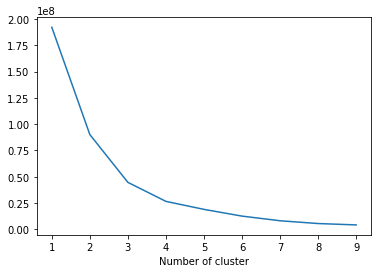

In [239]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Apply the same logic for having frequency clusters and assign this to each customer:

In [240]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0


Characteristics of our frequency clusters look like below:


In [241]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
tx_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850.0,301,0,312,1
1,15808.0,305,0,210,1
2,13047.0,31,3,196,1
3,14688.0,7,3,359,1
4,16029.0,38,3,274,1
...,...,...,...,...,...
3945,14056.0,0,3,1128,2
3946,14456.0,4,3,977,2
3947,12748.0,0,3,4642,3
3948,17841.0,1,3,7983,3


###### As the same notation as recency clusters, high frequency number indicates better customers.

# Revenue

Let’s see how our customer database looks like when we cluster them based on revenue. We will calculate revenue for each customer, plot a histogram and apply the same clustering method.

In [242]:
#calculate revenue for each customer
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()
tx_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [243]:
#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

In [244]:
tx_user.Revenue.describe()

count      3950.000000
mean       1713.385669
std        6548.608224
min       -4287.630000
25%         282.255000
50%         627.060000
75%        1521.782500
max      256438.490000
Name: Revenue, dtype: float64

In [245]:
#plot the histogram

plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

We have some customers with negative revenue as well. Let’s continue and apply k-means clustering:

In [246]:
import warnings
warnings.filterwarnings("ignore")

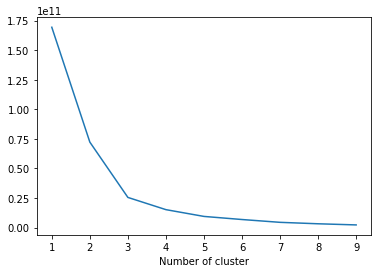

In [247]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [248]:
#apply clustering

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [249]:
#order the cluster numbers

tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [250]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


# Overall Segmentation

Awesome! We have scores (cluster numbers) for recency, frequency & revenue. Let’s create an overall score out of them:

In [251]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,301,0,312,1,5288.63,1
1,14688.0,7,3,359,1,5107.38,1
2,13767.0,1,3,399,1,16945.71,1
3,15513.0,30,3,314,1,14520.08,1
4,14849.0,21,3,392,1,7904.28,1


In [252]:
#calculate overall score and use mean() to see details

tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,17850.0,301,0,312,1,5288.63,1,2
1,14688.0,7,3,359,1,5107.38,1,5
2,13767.0,1,3,399,1,16945.71,1,5
3,15513.0,30,3,314,1,14520.08,1,5
4,14849.0,21,3,392,1,7904.28,1,5
...,...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,2,8
3946,17841.0,1,3,7983,3,40340.78,2,8
3947,14096.0,3,3,5128,3,57120.91,2,8
3948,17450.0,7,3,351,1,187482.17,3,7


In [253]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.362989,32.596085,498.087546
2,78.991304,46.963043,868.082991
3,20.689610,68.419590,1091.416414
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


#### The scoring above clearly shows us that customers with score 8 is our best customers whereas 0 is the worst.

In [254]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0     474
1     562
2     920
3    1511
4     298
5     148
6      27
7       7
8       3
Name: Recency, dtype: int64

To keep things simple, better we name these scores:
- 0 to 2: Low Value
- 3 to 4: Mid Value
- 5+: High Value

We can easily apply this naming on our dataframe:

In [255]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

tx_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value
...,...,...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,2,8,High-Value
3946,17841.0,1,3,7983,3,40340.78,2,8,High-Value
3947,14096.0,3,3,5128,3,57120.91,2,8,High-Value
3948,17450.0,7,3,351,1,187482.17,3,7,High-Value


### Now, it is the best part. Let’s see how our segments distributed on a scatter plot:

In [256]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [257]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [258]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#### We can start taking actions with this segmentation. The main strategies are quite clear:
- High Value: Improve Retention
- Mid Value: Improve Retention + Increase Frequency
- Low Value: Increase Frequency*